In [73]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

SYMBOL = 'GOOG'
start_date = '2016-01-01'
end_date = '2021-01-01'
SRC_DATA_FILENAME = SYMBOL + '_data.pkl'

try:
  data = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
  data = data.DataReader(SYMBOL, 'yahoo', start_date, end_date)
  data.to_pickle(SRC_DATA_FILENAME)


In [74]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10  # Static time period parameter for the fast EMA
# Static smoothing factor parameter for fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1)
ema_fast = 0
ema_fast_values = []  # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40  # Static time period parameter for slow EMA
# Static smoothing factor parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)
ema_slow = 0
ema_slow_values = []  # we will hold slow EMA values for visualization purposes

apo_values = []  # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = []  # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = []  # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = []  # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

# Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_buy_price = 0
# Price at which last sell trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0
position = 0  # Current position of the trading strategy
# Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_price_qty = 0
# Summation of buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0
# Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_price_qty = 0
# Summation of sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0
open_pnl = 0  # Open/Unrealized PnL marked to market
closed_pnl = 0  # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
# APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_BUY_ENTRY = -10
# APO trading signal value above which to enter sell-orders/short-position
APO_VALUE_FOR_SELL_ENTRY = 10
# Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
NUM_SHARES_PER_TRADE = 10  # Number of shares to buy/sell on every trade
# Minimum Open/Unrealized profit at which to close positions and lock profits
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE


In [75]:
orders = []
positions = []
pnls = []

last_buy_price = 0
last_sell_price = 0
position = 0
buy_sum_price_qty = 0
buy_sum_qty = 0
sell_sum_price_qty = 0
sell_sum_qty = 0
open_pnl = 0
closed_pnl = 0

APO_VALUE_FOR_BUY_ENTRY = -10
APO_VALUE_FOR_SELL_ENTRY = 10
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
MIN_PROFIT_TO_CLOSE = 10
NUM_SHARES_PER_TRADE = 10
MIN_PROFIT_TO_CLOSE = 10 * NUM_SHARES_PER_TRADE


In [76]:
close = data['Close']
for close_price in close:
  # This section updates fast and slow EMA and computes APO trading signal
  if (ema_fast == 0):  # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # This section checks trading signal against trading parameters/thresholds and positions, to trade.
  # We will perform a sell trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
  if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) or (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))):
    orders.append(-1)  # mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE  # reduce position by the size of this trade
    # update vwap sell-price
    sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)
    sell_sum_qty += NUM_SHARES_PER_TRADE
    
  # We will perform a buy trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
  elif ((apo < APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) or (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))):
    orders.append(+1)  # mark the buy trade
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE  # increase position by the size of this trade
    # update the vwap buy-price
    buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)
    buy_sum_qty += NUM_SHARES_PER_TRADE
  else:
    # No trade since none of the conditions were met to buy or sell
    orders.append(0)

  positions.append(position)

  # This section updates Open/Unrealized & Closed/Realized positions
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0:  # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(sell_sum_qty - position) * \
        (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0:  # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0
    
  pnls.append(closed_pnl + open_pnl)


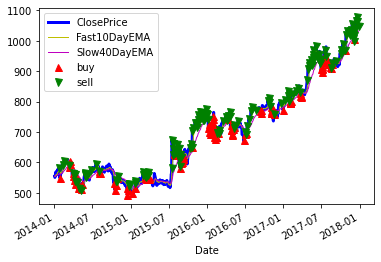

In [77]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)

plt.plot(data.loc[data.Trades == 1].index, data.ClosePrice[data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[data.Trades == -1].index, data.ClosePrice[data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')

plt.legend()
plt.show()


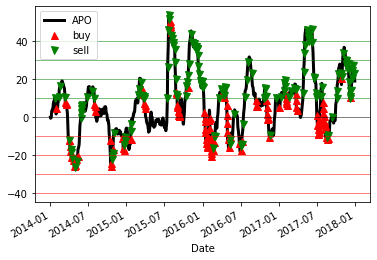

In [78]:
data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[data.Trades == 1].index, data.APO[data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[data.Trades == -1].index, data.APO[data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')

for i in range(APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY):
  plt.axhline(y=i, lw=0.5, color='r')

for i in range(APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY):
  plt.axhline(y=i, lw=0.5, color='g')

plt.legend()
plt.show()

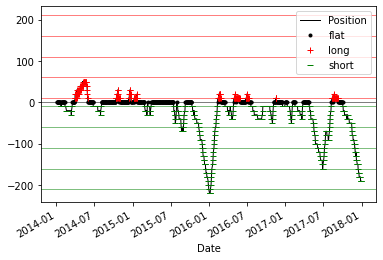

In [79]:
data['Position'].plot(color='k', lw=1., legend=True)

plt.plot(data.loc[data.Position == 0].index, data.Position[data.Position == 0], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[data.Position > 0].index, data.Position[data.Position > 0], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[data.Position < 0].index, data.Position[data.Position < 0], color='g', lw=0, marker='_', label='short')

plt.axhline(y=0, lw=0.5, color='k')
for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5):
  plt.axhline(y=i, lw=0.5, color='r')

for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5):
  plt.axhline(y=i, lw=0.5, color='g')

plt.legend()
plt.show()

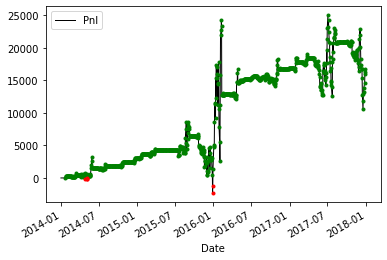

In [80]:
data['Pnl'].plot(color='k', lw=1., legend=True)

plt.plot(data.loc[data.Pnl > 0].index, data.Pnl[data.Pnl > 0], color='g', lw=0, marker='.')
plt.plot(data.loc[data.Pnl < 0].index, data.Pnl[data.Pnl < 0], color='r', lw=0, marker='.')

plt.legend()
plt.show()


In [81]:
data.to_csv("basic_mean_reversion.csv", sep=",")
# data.to_json('basic_mean_reversion.json')
